# 1. Setup of all libraries (follow straight order to not get errors!)

In [50]:
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [52]:
from torch.utils.data    import DataLoader
from torch.nn.functional import cross_entropy

In [53]:
import torch.nn as nn
from torchsummary import summary

### 1.1 Device Config 

In [54]:
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')

# 2. Get and transform data

In [55]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

In [56]:
root = './'
train = MNIST(root, train = True, transform = data_tfs, download = True)
test = MNIST(root, train = False, transform = data_tfs, download = True)

In [57]:
print(f'Data size:\n\t train {len(train)},\n\t test {len(train)}')
print(f'Data shape:\n\t train {train[0][0].shape},\n\t test {test[0][0].shape}')

Data size:
	 train 60000,
	 test 60000
Data shape:
	 train torch.Size([1, 28, 28]),
	 test torch.Size([1, 28, 28])


### 2.1 Create Batch

In [58]:
batch_size = 128

train_loader = DataLoader(train, batch_size = batch_size, drop_last = True)
test_loader  = DataLoader(test,  batch_size = batch_size, drop_last = True)

In [59]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

# 3. Set up the first model

Fitting the linear model:
1. For every class computate his own weights `logits` 
2. Use `softmax` on every `logits` to get probability
3. Learning with `sgd` based on `cross-entropy` function of losses

In [60]:
features = 28 * 28
classes  = 10

In [61]:
epochs = 5
lr      = 1e-2
history = []

In [62]:
#Initial weights 
w = torch.FloatTensor(features, classes).uniform_(-1, 1) / features**0.5
w.requires_grad_()

tensor([[ 0.0145,  0.0217, -0.0019,  ...,  0.0110, -0.0316,  0.0147],
        [-0.0099,  0.0233,  0.0149,  ...,  0.0016, -0.0317, -0.0268],
        [-0.0123,  0.0235, -0.0010,  ..., -0.0226,  0.0094, -0.0327],
        ...,
        [-0.0312,  0.0289,  0.0217,  ..., -0.0011, -0.0321, -0.0062],
        [ 0.0224,  0.0009,  0.0134,  ..., -0.0127, -0.0332,  0.0350],
        [ 0.0116, -0.0002,  0.0203,  ..., -0.0336,  0.0350, -0.0335]],
       requires_grad=True)

In [63]:
for i in range(epochs):
    for x_batch, y_batch in train_loader:

        x_batch = x_batch.reshape(x_batch.shape[0], -1)

        logits         = x_batch @ w
        probabilities  = torch.exp(logits) / torch.exp(logits).sum(dim = 1, keepdim = True)

        loss = -torch.log(probabilities[range(batch_size), y_batch]).mean()
        history.append(loss.item())
        loss.backward() #computates gradients 

        grad = w.grad
        with torch.no_grad():
            w -= lr * grad
        w.grad.zero_()
    print(f'{i+1}, \t loss: {history[-1]}')

1, 	 loss: 0.1966225802898407
2, 	 loss: 0.14063414931297302
3, 	 loss: 0.12039943039417267
4, 	 loss: 0.10950277745723724
5, 	 loss: 0.1024676188826561


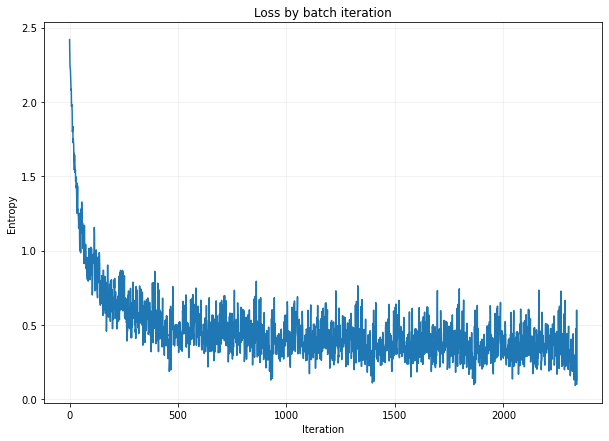

In [64]:
plt.figure(figsize  = (10, 7))
plt.plot(history)
plt.title('Loss by batch iteration')
plt.ylabel('Entropy')
plt.xlabel('Iteration')
plt.grid(alpha = 0.2)
plt.show()

In [65]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
    batches += 1

    x_batch = x_batch.view(x_batch.shape[0], -1)
    y_batch = y_batch

    preds = torch.argmax(x_batch @ w, dim = 1)
    acc += (preds == y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.907


# 4. Set up of second, more complicated model

Chosing the model

`nn.Linear`

`nn.Softmax`, `nn.LogSoftmax`

`nn.ReLU`, `nn.ELU`, `nn.LeakyReLU`

`nn.Tanh`, `nn.Sigmoid`

`nn.LSTM`, `nn.GRU`

`nn.Conv1d`, `nn.Conv2d`

`nn.MaxPool1d`, `nn.AdaptiveMaxPool1d` and others pooling

`nn.BatchNorm1d`, `nn.BatchNorm2d`

`nn.Dropout`

losses: `nn.CrossEntropyLoss`, `nn.NLLLoss`, `nn.MSELoss`
etc

In [67]:
model = nn.Sequential(
    nn.Linear(features, 64),
    nn.ReLU(),
    nn.Linear(64, classes)
)

# It is the same as:
# model = nn.Sequential()
# model.add_module('0', nn.Linear(features, 64))
# model.add_module('1', nn.Linear(64, classes))

model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
)

In [69]:
summary(model, (features,), batch_size = 228) #to check if everything is ok

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [228, 64]          50,240
              ReLU-2                  [228, 64]               0
            Linear-3                  [228, 10]             650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.68
Forward/backward pass size (MB): 0.24
Params size (MB): 0.19
Estimated Total Size (MB): 1.12
----------------------------------------------------------------


Ideas for optimizer

`torch.optim.Adam` - [paper] (https://arxiv.org/abs/1412.6980)

`torch.optim.SGD` - casual SGD

`torch.optim.Adagrad` - [article] (https://jmlr.org/papers/v12/duchi11a.html)

`torch.optim.RMSprop` - [slides] (https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)

In [70]:
criteria  = nn.CrossEntropyLoss() #(logsoftmax + negative likelihood)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, betas = (0.9, 0.99))

In [71]:
epochs = 3
history = []

In [76]:
for i in range(epochs):
    for x_batch, y_batch in train_loader:

        x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
        y_batch = y_batch.to(device)

        logits = model(x_batch)

        loss = criteria(logits, y_batch)
        history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    print(f'{i+1}, \t loss: {history[-1]}')

1, 	 loss: 0.03192576393485069
2, 	 loss: 0.025674520060420036
3, 	 loss: 0.02014310471713543


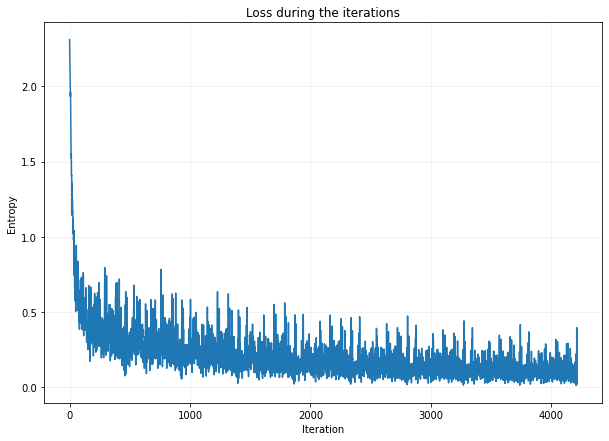

In [79]:
plt.figure(figsize = (10, 7))
plt.plot(history)
plt.title('Loss during the iterations')
plt.xlabel('Iteration')
plt.ylabel('Entropy')
plt.grid(alpha = 0.2)
plt.show()

In [81]:
acc     = 0
batches = 0

for x_batch, y_batch in test_loader:
    batches += 1

    x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
    y_batch = y_batch.to(device)

    preds = torch.argmax(model(x_batch), dim = 1)
    acc   += (preds == y_batch).cpu().numpy().mean()

print(f'Accuracy score is {acc / batches:.3}')


Accuracy score is 0.959


Our two-layers Neural Network (without Softmax) gave us worse results than usual SGD Linear Regression model